In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import os
import matplotlib.animation as animation
import pandas as pd
from PIL import Image
import matplotlib.image

r2d=180/np.pi
d2r=np.pi/180

series = 'MOT_300K_4S_TR_1_LITE_06_0p3'

fig2,ax2 = plt.subplots(figsize=(10, 10))
rot1=45
rot2=45
rot3=0
r = R.from_euler('zyx', [rot1, rot2, rot3], degrees=True)

segs_fn = 'Z:/PHD/pcseg/results/'+series+'_SEGSCENT.csv'
ncol_fn = 'Z:/PHD/pcseg/results/'+series+'_SEGSCENT_NC.csv'
segs = pd.read_csv(segs_fn,header=None).to_numpy()
ncol = pd.read_csv(ncol_fn,header=None).to_numpy()


csv_path = 'Z:/PHD/pcseg/results/lrg/'+series
csv_names = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(csv_path)) for f in fn]
csv_names.sort()

# get poses
sequence ='06'
# get camera calibration
calib_file = open('Z:\data_odometry_velodyne\dataset\sequences\\' + sequence + '\calib.txt', 'r')
calib = {}
for line in calib_file:
    key, content = line.strip().split(":")
    values = [float(v) for v in content.strip().split()]
    pose = np.zeros((4, 4))
    pose[0, 0:4] = values[0:4]
    pose[1, 0:4] = values[4:8]
    pose[2, 0:4] = values[8:12]
    pose[3, 3] = 1.0
    calib[key] = pose
calib_file.close()
poses = []
Tr = calib["Tr"]
Tr_inv = np.linalg.inv(Tr)
pose_file = open('Z:\data_odometry_velodyne\dataset\sequences\\' + sequence + '\poses.txt', 'r')
for line in pose_file:
    values = [float(v) for v in line.strip().split()]
    pose = np.zeros((4, 4))
    pose[0, 0:4] = values[0:4]
    pose[1, 0:4] = values[4:8]
    pose[2, 0:4] = values[8:12]
    pose[3, 3] = 1.0
    poses.append(np.matmul(Tr_inv, np.matmul(pose, Tr)))
pose_file.close()




scale = 8
ims = []
imgsz = 1000

N_frames = len(csv_names)

for i in range(N_frames):
    
    ss_idx=segs[:,0]==i
    ss=segs[ss_idx]
    ss_st=ss_idx.tolist().index(True)
    Nss=ss.shape[0]
    ss_cols=[]
    for k in range(Nss):
        ss_cols.append((ss[k,1],ss[k,2],ss[k,3]))
    
    R_world_local = poses[i][:3, :3]
    t_world_local = poses[i][:3, 3]
    R_local_world = np.linalg.inv(R_world_local)
    
    print(i)
    rgb=np.zeros((imgsz,imgsz,3),dtype=np.uint8)
    
    cloud = pd.read_csv(csv_names[i],header=None).to_numpy()
    npt = cloud.shape[0]
    print(npt)
    
    for k in range(npt):
        cx=cloud[k,0]
        cy=cloud[k,1]
        cz=cloud[k,2]
        xyz_w=np.asarray([cx,cy,cz])
        xyz_l=xyz_w - t_world_local
        #xyz_l=xyz_l.dot(R_local_world.T) 
        
        vr=r.apply([xyz_l[0],xyz_l[1],xyz_l[2]])
        x=int(vr[0]*scale)+int(imgsz/2)
        y=int(vr[1]*scale)+int(imgsz/2)
        if (x>=1) and (x<imgsz-1) and (y>=1) and (y<imgsz-1): # and (cloud[k,10]==0):
            rr=int(cloud[k,3])
            gg=int(cloud[k,4])
            bb=int(cloud[k,5])
            rgbt=(rr,gg,bb)
            rgbt_i=ss_cols.index(rgbt)
            newc_i=ss_st+rgbt_i
            rr=int(ncol[newc_i,0])
            gg=int(ncol[newc_i,1])
            bb=int(ncol[newc_i,2])
            rgb[x,y,0]=rr
            rgb[x,y,1]=gg
            rgb[x,y,2]=bb
            rgb[x+1,y,0]=rr
            rgb[x+1,y,1]=gg
            rgb[x+1,y,2]=bb
            rgb[x-1,y,0]=rr
            rgb[x-1,y,1]=gg
            rgb[x-1,y,2]=bb
            rgb[x,y+1,0]=rr
            rgb[x,y+1,1]=gg
            rgb[x,y+1,2]=bb
            rgb[x,y-1,0]=rr
            rgb[x,y-1,1]=gg
            rgb[x,y-1,2]=bb

    im = ax2.imshow(rgb, animated=True)
    ims.append([im])
    matplotlib.image.imsave('Z:/PHD/pcseg/TRACKS/'+sequence+'/KITTI_RES_'+series+'_'+str(i)+'.png', rgb)
    
#ani = animation.ArtistAnimation(fig2, ims, interval=50, blit=True, repeat_delay=1000)
#ani.save("Z:/PHD/pcseg/results/SEG_Anim_Local_"+series+"_V2.gif")

In [ ]:
# KF TRACKING AND PLOT TRACK CENTROIDS

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import os
import matplotlib.animation as animation
import pandas as pd
from PIL import Image
import matplotlib.image

class KalmanFilter(object):
    def __init__(self, dt, u_x,u_y,u_z, std_acc, x_std_meas, y_std_meas, z_std_meas):
        """
        :param dt: sampling time (time for 1 cycle)
        :param u_x: acceleration in x-direction
        :param u_y: acceleration in y-direction
        :param u_z: acceleration in z-direction
        :param std_acc: process noise magnitude
        :param x_std_meas: standard deviation of the measurement in x-direction
        :param y_std_meas: standard deviation of the measurement in y-direction
        :param z_std_meas: standard deviation of the measurement in z-direction
        """
        # Define sampling time
        self.dt = dt
        # Define the  control input variables
        self.u = np.matrix([[u_x],[u_y],[u_z]])
        # Intial State
        self.x = np.matrix([[0], [0], [0], [0], [0], [0]])
        # Define the State Transition Matrix A
        self.A = np.matrix([[1, 0, 0, self.dt, 0, 0],
                            [0, 1, 0, 0, self.dt, 0],
                            [0, 0, 1, 0, 0, self.dt],
                            [0, 0, 0, 1, 0, 0],
                            [0, 0, 0, 0, 1, 0],
                            [0, 0, 0, 0, 0, 1]])
        # Define the Control Input Matrix B
        self.B = np.matrix([[(self.dt**2)/2, 0, 0],
                            [0, (self.dt**2)/2, 0],
                            [0, 0, (self.dt**2)/2],
                            [self.dt, 0, 0],
                            [0, self.dt, 0],
                            [0, 0,self.dt]])
        # Define Measurement Mapping Matrix
        self.H = np.matrix([[1, 0, 0, 0, 0, 0],
                            [0, 1, 0, 0, 0, 0],
                            [0, 0, 1, 0, 0, 0]])
        #Initial Process Noise Covariance
        self.Q = np.matrix([[(self.dt**4)/4, 0, 0, (self.dt**3)/2, 0, 0],
                            [0, (self.dt**4)/4, 0, 0, (self.dt**3)/2 ,0],
                            [0, 0, (self.dt**4)/4, 0, 0, (self.dt**3)/2],
                            [(self.dt**3)/2, 0, 0, self.dt**2, 0, 0],
                            [0, (self.dt**3)/2, 0, 0, self.dt**2, 0],
                            [0, 0, (self.dt**3)/2, 0, 0, self.dt**2]]) * std_acc**2
        #Initial Measurement Noise Covariance
        self.R = np.matrix([[x_std_meas**2, 0, 0],
                            [0, y_std_meas**2, 0],
                            [0, 0, z_std_meas**2]])
        #Initial Covariance Matrix
        self.P = np.eye(self.A.shape[1])
        
    def predict(self):
        # Refer to :Eq.(9) and Eq.(10)  in https://machinelearningspace.com/object-tracking-simple-implementation-of-kalman-filter-in-python/?preview_id=1364&preview_nonce=52f6f1262e&preview=true&_thumbnail_id=1795
        # Update time state
        #x_k =Ax_(k-1) + Bu_(k-1)     Eq.(9)
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)
        # Calculate error covariance
        # P= A*P*A' + Q               Eq.(10)
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x[0:3]
    
    def update(self, z):
        # Refer to :Eq.(11), Eq.(12) and Eq.(13)  in https://machinelearningspace.com/object-tracking-simple-implementation-of-kalman-filter-in-python/?preview_id=1364&preview_nonce=52f6f1262e&preview=true&_thumbnail_id=1795
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        # Calculate the Kalman Gain
        # K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  #Eq.(11)
        self.x = self.x + np.dot(K, (z - np.dot(self.H, self.x)))   #Eq.(12)
        I = np.eye(self.H.shape[1])
        # Update error covariance matrix
        self.P = (I - (K * self.H)) * self.P   #Eq.(13)
        return self.x[0:3]

r2d=180/np.pi
d2r=np.pi/180

#series = 'MOT_300K_4S_TR_1_LITE_06_0p3'
series = 'MOT_300K_4S_TR_1_LITE'

#fig2,ax2 = plt.subplots(figsize=(10, 10))
rot1=45
rot2=45
rot3=0
r = R.from_euler('zyx', [rot1, rot2, rot3], degrees=True)

segs_fn = 'Z:/PHD/pcseg/results/'+series+'_SEGSHOTA.csv'
ncol_fn = 'Z:/PHD/pcseg/results/'+series+'_SEGSHOTA_NC.csv'
segs = pd.read_csv(segs_fn,header=None).to_numpy()
ncol = pd.read_csv(ncol_fn,header=None).to_numpy()


csv_path = 'Z:/PHD/pcseg/results/lrg/'+series
csv_names = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(csv_path)) for f in fn]
csv_names.sort()

# get poses
sequence ='01'
# get camera calibration
calib_file = open('Z:\data_odometry_velodyne\dataset\sequences\\' + sequence + '\calib.txt', 'r')
calib = {}
for line in calib_file:
    key, content = line.strip().split(":")
    values = [float(v) for v in content.strip().split()]
    pose = np.zeros((4, 4))
    pose[0, 0:4] = values[0:4]
    pose[1, 0:4] = values[4:8]
    pose[2, 0:4] = values[8:12]
    pose[3, 3] = 1.0
    calib[key] = pose
calib_file.close()
poses = []
Tr = calib["Tr"]
Tr_inv = np.linalg.inv(Tr)
pose_file = open('Z:\data_odometry_velodyne\dataset\sequences\\' + sequence + '\poses.txt', 'r')
for line in pose_file:
    values = [float(v) for v in line.strip().split()]
    pose = np.zeros((4, 4))
    pose[0, 0:4] = values[0:4]
    pose[1, 0:4] = values[4:8]
    pose[2, 0:4] = values[8:12]
    pose[3, 3] = 1.0
    poses.append(np.matmul(Tr_inv, np.matmul(pose, Tr)))
pose_file.close()

print(segs.shape)
print(ncol.shape)
alldata=np.hstack((segs,ncol))
print(alldata.shape)
N=alldata.shape[0]
unique_nc=np.unique(ncol, axis=0)
print(unique_nc.shape)
NT=unique_nc.shape[0]
print(N,NT)
print(unique_nc)

scale = 1
imgsz=1000

f = open('Z:/PHD/pcseg/results/'+series+'_TRACKING_H.csv','w')

for i in range(NT):
    tr_idx=[]
    for j in range(N):
        if unique_nc[i,0]==ncol[j,0] and unique_nc[i,1]==ncol[j,1] and unique_nc[i,2]==ncol[j,2]:
            tr_idx.append(j)
    ss=alldata[tr_idx]
    NPS=len(tr_idx)
    if NPS>0:
        KF = KalmanFilter(0.1, 1, 1, 1, 1, 0.1,0.1,0.1)
        (kfpx, kfpy, kfpz) = KF.predict()
        frame_id0=int(ss[0,0])
        R_world_local = poses[frame_id0][:3, :3]
        t_world_local = poses[frame_id0][:3, 3]
        R_local_world = np.linalg.inv(R_world_local)
        cx0=ss[0,5]
        cy0=ss[0,6]
        cz0=ss[0,7]
        (kfcx, kfcy, kfcz) = KF.update([[cx0],[cy0],[cz0]])
        
        for j in range(1,NPS):
            # Start Point
            frame_id1=int(ss[j-1,0])
            R_world_local = poses[frame_id1][:3, :3]
            t_world_local = poses[frame_id1][:3, 3]
            R_local_world = np.linalg.inv(R_world_local)
            cx1=ss[j-1,5]
            cy1=ss[j-1,6]
            cz1=ss[j-1,7]
            xyz_w1=np.asarray([cx1,cy1,cz1])
            xyz_l1=xyz_w1 - t_world_local
            xyz_l1=xyz_l1.dot(R_local_world) 
            vr=r.apply([xyz_l1[0],xyz_l1[1],xyz_l1[2]])
            #vr=r.apply([cx1,cy1,cz1])
            x1=int(vr[0]*scale)+int(imgsz/2)
            y1=int(vr[1]*scale)+int(imgsz/2)
            
            # End Point
            frame_id2=int(ss[j,0])
            R_world_local = poses[frame_id2][:3, :3]
            t_world_local = poses[frame_id2][:3, 3]
            R_local_world = np.linalg.inv(R_world_local)
            cx2=ss[j,5]
            cy2=ss[j,6]
            cz2=ss[j,7]
            xyz_w2=np.asarray([cx2,cy2,cz2])
            xyz_l2=xyz_w2 - t_world_local
            xyz_l2=xyz_l2.dot(R_local_world) 
            vr=r.apply([xyz_l2[0],xyz_l2[1],xyz_l2[2]])
            #vr=r.apply([cx2,cy2,cz2])
            x2=int(vr[0]*scale)+int(imgsz/2)
            y2=int(vr[1]*scale)+int(imgsz/2)
            
            #plt.plot([x1,x2], [y1,y2], '-', color=(unique_nc[i,0]/255,unique_nc[i,1]/255,unique_nc[i,2]/255))
            
            kfcx_old=kfcx
            kfcy_old=kfcy
            kfcz_old=kfcz
            (kfpx, kfpy, kfpz) = KF.predict()
            (kfcx, kfcy, kfcz) = KF.update([[cx2],[cy2],[cz2]])
            #print(kfcx_old,kfcy_old,kfcx, kfcy,cx1,cy1,cx2,cy2)
            
            frame_id1=int(ss[j-1,0])
            R_world_local = poses[frame_id1][:3, :3]
            t_world_local = poses[frame_id1][:3, 3]
            R_local_world = np.linalg.inv(R_world_local)
            xyz_w1=np.asarray([kfcx_old[0,0],kfcy_old[0,0],kfcz_old[0,0]])
            xyz_l1=xyz_w1 - t_world_local
            xyz_l1=xyz_l1.dot(R_local_world) 
            vr=r.apply([xyz_l1[0],xyz_l1[1],xyz_l1[2]])
            #vr=r.apply([kfcx_old[0,0],kfcy_old[0,0],kfcz_old[0,0]])
            x1=int(vr[0]*scale)+int(imgsz/2)
            y1=int(vr[1]*scale)+int(imgsz/2)
            
            frame_id2=int(ss[j,0])
            R_world_local = poses[frame_id2][:3, :3]
            t_world_local = poses[frame_id2][:3, 3]
            R_local_world = np.linalg.inv(R_world_local)
            xyz_w2=np.asarray([kfcx[0,0],kfcy[0,0],kfcz[0,0]])
            xyz_l2=xyz_w2 - t_world_local
            xyz_l2=xyz_l2.dot(R_local_world) 
            vr=r.apply([xyz_l2[0],xyz_l2[1],xyz_l2[2]])
            #vr=r.apply([kfcx[0,0],kfcy[0,0],kfcz[0,0]])
            x2=int(vr[0]*scale)+int(imgsz/2)
            y2=int(vr[1]*scale)+int(imgsz/2)

            #plt.plot([x1,x2], [y1,y2], '-', color=(unique_nc[i,0]/512,unique_nc[i,1]/512,unique_nc[i,2]/512))
            
            f.write("%d,%d,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%d,%d\n"%(i,j,cx1,cy1,cz1,cx2,cy2,cz2,kfcx_old[0,0],kfcy_old[0,0],kfcz_old[0,0],kfcx[0,0],kfcy[0,0],kfcz[0,0],frame_id1,frame_id2))
            
plt.axis('equal')
plt.show()

f.close()
            

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import os
import matplotlib.animation as animation
import pandas as pd
from PIL import Image

r2d=180/np.pi
d2r=np.pi/180

fig2,ax2 = plt.subplots(figsize=(10, 10))
rot1=45
rot2=45
rot3=0
r = R.from_euler('zyx', [rot1, rot2, rot3], degrees=True)


csv_path = 'Z:/PHD/pcseg/results/lrg/MOT_300K_4S_TR_1_LITE_06_0p3/'
csv_names = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(csv_path)) for f in fn]
csv_names.sort()

# get poses
sequence ='01'
# get camera calibration
calib_file = open('Z:\data_odometry_velodyne\dataset\sequences\\' + sequence + '\calib.txt', 'r')
calib = {}
for line in calib_file:
    key, content = line.strip().split(":")
    values = [float(v) for v in content.strip().split()]
    pose = np.zeros((4, 4))
    pose[0, 0:4] = values[0:4]
    pose[1, 0:4] = values[4:8]
    pose[2, 0:4] = values[8:12]
    pose[3, 3] = 1.0
    calib[key] = pose
calib_file.close()
poses = []
Tr = calib["Tr"]
Tr_inv = np.linalg.inv(Tr)
pose_file = open('Z:\data_odometry_velodyne\dataset\sequences\\' + sequence + '\poses.txt', 'r')
for line in pose_file:
    values = [float(v) for v in line.strip().split()]
    pose = np.zeros((4, 4))
    pose[0, 0:4] = values[0:4]
    pose[1, 0:4] = values[4:8]
    pose[2, 0:4] = values[8:12]
    pose[3, 3] = 1.0
    poses.append(np.matmul(Tr_inv, np.matmul(pose, Tr)))
pose_file.close()




scale = 10
ims = []
imgsz = 1000

N_frames = len(csv_names)

for i in range(N_frames):
    
    R_world_local = poses[i][:3, :3]
    t_world_local = poses[i][:3, 3]
    R_local_world = np.linalg.inv(R_world_local)
    
    print(i)
    rgb=np.zeros((imgsz,imgsz,3),dtype=np.uint8)
    
    cloud = pd.read_csv(csv_names[i],header=None).to_numpy()
    npt = cloud.shape[0]
    print(npt)
    
    for k in range(npt):
        cx=cloud[k,0]
        cy=cloud[k,1]
        cz=cloud[k,2]
        xyz_w=np.asarray([cx,cy,cz])
        xyz_l=xyz_w - t_world_local
        xyz_l=xyz_l.dot(R_local_world.T) 
        
        vr=r.apply([xyz_l[0],xyz_l[1],xyz_l[2]])
        x=int(vr[0]*scale)+int(imgsz/2)
        y=int(vr[1]*scale)+int(imgsz/2)
        if (x>=1) and (x<imgsz-1) and (y>=1) and (y<imgsz-1):
            motion=cloud[k,6]
            if motion>0:
                rr=255
                gg=0
                bb=0
            else:
                rr=100
                gg=100
                bb=100
            rgb[x,y,0]=rr
            rgb[x,y,1]=gg
            rgb[x,y,2]=bb
            rgb[x+1,y,0]=rr
            rgb[x+1,y,1]=gg
            rgb[x+1,y,2]=bb
            rgb[x-1,y,0]=rr
            rgb[x-1,y,1]=gg
            rgb[x-1,y,2]=bb
            rgb[x,y+1,0]=rr
            rgb[x,y+1,1]=gg
            rgb[x,y+1,2]=bb
            rgb[x,y-1,0]=rr
            rgb[x,y-1,1]=gg
            rgb[x,y-1,2]=bb

    im = ax2.imshow(rgb, animated=True)
    ims.append([im])
    
ani = animation.ArtistAnimation(fig2, ims, interval=200, blit=True, repeat_delay=1000)
ani.save("Z:/PHD/pcseg/results/MOT_300K_4S_TR_1_LITE_06_0p6_2.gif")

In [1]:
# Track Creation with HOTA metrics

import math
import numpy as np

import os
import pandas as pd

#series = 'MOT_300K_4S_TR_1_LITE_06_0p3'
series = 'MOT_600K_4S_TR_1_LITE_07_0p3'

csv_path = 'Z:/PHD/pcseg/results/lrg/'+series
csv_names = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(csv_path)) for f in fn]
csv_names.sort()
#print(csv_names)

N_frames = len(csv_names)

f = open('Z:/PHD/pcseg/results/'+series+'_SEGSHOTA.csv','w')


for i in range(N_frames):
    
    fn_path = 'Z:/PHD/pcseg/results/lrg/' + series + '/M_'+str(i)+'.csv'
    
    cloud = pd.read_csv(fn_path,header=None).to_numpy()
    npt = cloud.shape[0]
    
    
    segs=set()
    for k in range(npt):
        rr=int(cloud[k,3])
        gg=int(cloud[k,4])
        bb=int(cloud[k,5])
        rgbt=(rr,gg,bb)
        segs.add(rgbt)
        
    segs=list(segs)
    N_s=len(segs)
    centroids=np.zeros((N_s,3),dtype=np.float64)
    segcounts=np.zeros((N_s),dtype=np.int32)
    bboxs=np.zeros((N_s,6),dtype=np.float64)
    
    for k in range(N_s):
        bboxs[k,0]= 1000000000.0 # min x
        bboxs[k,1]= 1000000000.0 # min y
        bboxs[k,2]= 1000000000.0 # min z
        bboxs[k,3]=-1000000000.0 # max x
        bboxs[k,4]=-1000000000.0 # max y
        bboxs[k,5]=-1000000000.0 # max z

    for k in range(npt):
        cx=cloud[k,0]
        cy=cloud[k,1]
        cz=cloud[k,2]
        rr=cloud[k,3]
        gg=cloud[k,4]
        bb=cloud[k,5]
        rgbt=(rr,gg,bb)
        indx=segs.index(rgbt)
        centroids[indx,0]+=cx
        centroids[indx,1]+=cy
        centroids[indx,2]+=cz
        if cx<bboxs[indx,0]:
            bboxs[indx,0]=cx
        if cy<bboxs[indx,1]:
            bboxs[indx,1]=cy
        if cz<bboxs[indx,2]:
            bboxs[indx,2]=cz
        if cx>bboxs[indx,3]:
            bboxs[indx,3]=cx
        if cy>bboxs[indx,4]:
            bboxs[indx,4]=cy
        if cz>bboxs[indx,5]:
            bboxs[indx,5]=cz
        
        
        segcounts[indx]+=1

    for k in range(N_s):
        centroids[k,0]/=float(segcounts[k])
        centroids[k,1]/=float(segcounts[k])
        centroids[k,2]/=float(segcounts[k])
        f.write("%d,%d,%d,%d,%d,%f,%f,%f,%f,%f,%f,%f,%f,%f\n"%(
        i,segs[k][0],segs[k][1],segs[k][2],segcounts[k],centroids[k,0],centroids[k,1],centroids[k,2],
        bboxs[k,0],bboxs[k,1],bboxs[k,2],bboxs[k,3],bboxs[k,4],bboxs[k,5]))

    print(i,npt,N_s)
    
f.close()

0 40638 8
1 40963 9
2 41178 5
3 41710 6
4 42061 5
5 42401 5
6 42899 7
7 43334 10
8 43775 13
9 44123 18
10 44413 14
11 44671 13
12 44546 10
13 44634 10
14 44993 17
15 45386 19
16 45669 12
17 46543 6
18 47068 8
19 47574 8
20 47837 14
21 48331 5
22 48769 5
23 49182 7
24 49250 8
25 49209 8
26 49041 13
27 48624 13
28 48334 17
29 48083 15
30 47621 15
31 47039 13
32 47036 16
33 46595 22
34 46374 25
35 45542 18
36 45010 18
37 44395 20
38 43694 31
39 42879 31
40 42113 24
41 41133 26
42 40305 23
43 39221 24
44 38287 29
45 37171 18
46 36467 12
47 35973 15
48 36130 16
49 36193 15
50 36511 16
51 36800 15
52 37081 21
53 37643 23
54 38167 20
55 38439 20
56 38716 19
57 38937 15
58 38953 17
59 39235 12
60 39086 23
61 38958 31
62 38980 29
63 38864 25
64 38845 33
65 38979 30
66 38826 19
67 38558 21
68 38398 18
69 38002 20
70 38131 15
71 37986 19
72 37892 24
73 37703 25
74 37318 20
75 37049 21
76 36956 23
77 37035 25
78 36763 27
79 36675 13
80 36844 19
81 37174 21
82 37393 20
83 37972 16
84 38291 14
85 39

665 34261 17
666 32504 14
667 30834 24
668 30706 25
669 30916 20
670 30840 18
671 30882 24
672 30830 19
673 30627 20
674 31057 24
675 31238 22
676 31017 21
677 31059 25
678 31067 25
679 31037 22
680 30880 22
681 30811 26
682 30356 22
683 30192 27
684 29972 28
685 29725 32
686 29364 22
687 29061 25
688 28504 22
689 28286 22
690 28166 23
691 28313 20
692 28075 23
693 27716 22
694 27341 23
695 27276 21
696 27087 16
697 27115 14
698 27133 16
699 27441 16
700 28473 30
701 29540 31
702 30121 31
703 30401 37
704 31126 33
705 32044 41
706 32708 32
707 33299 40
708 34549 22
709 35391 28
710 35948 21
711 37198 21
712 38504 13
713 39763 11
714 40773 11
715 41661 10
716 42418 4
717 43266 4
718 43928 10
719 44868 9
720 45434 8
721 46261 5
722 46986 3
723 47643 3
724 48334 3
725 48923 3
726 49285 3
727 49881 3
728 50600 4
729 51358 2
730 51924 4
731 52507 3
732 52620 7
733 52819 3
734 52846 5
735 53157 6
736 53838 4
737 54371 10
738 55053 5
739 55945 6
740 56840 6
741 57725 4
742 57997 12
743 58530 

In [2]:
# Track Association for HOTA
from scipy.optimize import linear_sum_assignment
import math
import numpy as np

import os
import pandas as pd

#series = 'MOT_300K_4S_TR_1_LITE_06_0p3'
series = 'MOT_600K_4S_TR_1_LITE_07_0p3'

IOU_t = 0.6
min_prat = 0.5
max_prat = 2.0


def Voxel_IoU(v1,v2):
    IoU = 0
    set1=set()
    for i in range(v1.shape[0]):
        voxel=(v1[i,0],v1[i,1],v1[i,2])
        set1.add(voxel)
    set2=set()
    for i in range(v2.shape[0]):
        voxel=(v2[i,0],v2[i,1],v2[i,2])
        set2.add(voxel)
        
    inter = set1 & set2
    union = set1 | set2
    if len(union)>0:
        IoU=len(inter)/len(union)
    
    return IoU

def VoxelPC_TrackerMC(cloud,rr,gg,bb,resolution):
    #cloud1 = pd.read_csv(M_fn_1,header=None).to_numpy()
    #cloud2 = pd.read_csv(M_fn_2,header=None).to_numpy()
    
    npt = cloud.shape[0]
    nc = 0
    for i in range(npt):
        if int(cloud[i,3])==rr and int(cloud[i,4])==gg and int(cloud[i,5])==bb:
            nc = nc + 1
            
    PC = np.zeros((nc,3))
    ni = 0
    for i in range(npt):
        if int(cloud[i,3])==rr and int(cloud[i,4])==gg and int(cloud[i,5])==bb:
            PC[ni,0]=cloud[i,0]
            PC[ni,1]=cloud[i,1]
            PC[ni,2]=cloud[i,2]
            ni = ni + 1
            
    return np.round(PC/resolution).astype(int)

csv_fn = 'Z:/PHD/pcseg/results/'+series+'_SEGSHOTA.csv'

segs = pd.read_csv(csv_fn,header=None).to_numpy()
nframes = int(np.max(segs[:,0]))
print(nframes)
N = segs.shape[0]
newcols = np.zeros((N,3),dtype=np.int32)

for i in range(N):
    newcols[i,0]=int(segs[i,1])
    newcols[i,1]=int(segs[i,2])
    newcols[i,2]=int(segs[i,3])

for i in range(nframes-1):
    indx1=i
    indx2=i+1
    s1_idx=segs[:,0]==indx1
    s2_idx=segs[:,0]==indx2
    ss1=segs[s1_idx]
    ss2=segs[s2_idx]
    s1_st=s1_idx.tolist().index(True)
    s2_st=s2_idx.tolist().index(True)
    N1=ss1.shape[0]
    N2=ss2.shape[0]
    print('Raw Frame Data: ',indx1,indx2,N1,N2,s1_st,s2_st)
    CM=np.zeros((N1,N2),dtype=np.float64)
    for k in range(N1):
        for m in range(N2):
            CM[k,m]=np.linalg.norm([ss1[k,5]-ss2[m,5],ss1[k,6]-ss2[m,6],ss1[k,7]-ss2[m,7]])
            
            
    cloud1 = pd.read_csv('Z:/PHD/pcseg/results/lrg/'+series+'/M_'+str(i  )+'.csv',header=None).values
    cloud2 = pd.read_csv('Z:/PHD/pcseg/results/lrg/'+series+'/M_'+str(i+1)+'.csv',header=None).values
    NT1=cloud1.shape[0]
    NT2=cloud2.shape[0]
    
    # Frame 1
    s1=set()
    for i in range(NT1):
        rgb=(int(cloud1[i,3]),int(cloud1[i,4]),int(cloud1[i,5]))
        s1.add(rgb)
    NC1=len(s1)
    
    # Frame 2
    s2=set()
    for i in range(NT2):
        rgb=(int(cloud2[i,3]),int(cloud2[i,4]),int(cloud2[i,5]))
        s2.add(rgb)
    NC2=len(s2)
    
    
    print('Point Cloud Segments: ',i,NT1,NT2,NC1,NC2)

    IOU=np.zeros((NC1,NC2))

    voxels1=[]
    voxels2=[]

    for ss in s1:
        v=VoxelPC_TrackerMC(cloud1,ss[0],ss[1],ss[2],0.3)
        voxels1.append(v)
    
    for ss in s2:
        v=VoxelPC_TrackerMC(cloud2,ss[0],ss[1],ss[2],0.3)
        voxels2.append(v)


    # Calculate voxel IOUs given point-count-ratios within acceptable range
    for i in range(NC1):
        #print(i)
        npt1 = len(voxels1[i])
        for j in range(NC2):
            npt2 = len(voxels2[j])
            rat = 0
            if npt1 > 0:
                rat = float(npt2)/float(npt1)
            if rat >= min_prat and rat <= max_prat:
                IOU[i,j]=Voxel_IoU(voxels1[i],voxels2[j])
    
    # Apply IOU Threshold gating
    for i in range(NC1):
        for j in range(NC2):
            if IOU[i,j] <= IOU_t:
                IOU[i,j]=0
            
    #row_ind, col_ind = linear_sum_assignment(CM)
    row_ind, col_ind = linear_sum_assignment(-IOU)
    print('Assignment : ',len(row_ind),len(col_ind),NC1,NC2)
    for k in range(len(col_ind)):
        
        col_i = col_ind[k]
        row_i = row_ind[k]
        
        # Associate only if a valid IOU was present between the 2 candidates
        if IOU[row_i,col_i] > 0:
            newcols[s2_st+col_i,0]=newcols[s1_st+row_i,0]
            newcols[s2_st+col_i,1]=newcols[s1_st+row_i,1]
            newcols[s2_st+col_i,2]=newcols[s1_st+row_i,2]
    #print(row_ind,col_ind)
    
# Unique Track IDs
trackids = np.zeros((N),dtype=np.int32)
trks=set()
for k in range(N):
    rn=newcols[k,0]
    gn=newcols[k,1]
    bn=newcols[k,2]
    rgbn=(rn,gn,bn)
    trks.add(rgbn)
trks=list(trks)
N_t=len(trks)
print('Total Unique Tracks: ',N_t)
for k in range(N):
    trackids[k]=-1
    rn=newcols[k,0]
    gn=newcols[k,1]
    bn=newcols[k,2]
    rgbn=(rn,gn,bn)
    indx=trks.index(rgbn)
    trackids[k]=indx
    
f = open('Z:/PHD/pcseg/results/'+series+'_SEGSHOTA_NC.csv','w')
for i in range(N):
    f.write("%d,%d,%d,%d,%d,%f,%f,%f,%f,%f,%f,%d,%d,%d\n"%(
        newcols[i,0],newcols[i,1],newcols[i,2],segs[i,0],trackids[i],
        segs[i,8],segs[i,9],segs[i,10],segs[i,11],segs[i,12],segs[i,13],int(segs[i,1]),int(segs[i,2]),int(segs[i,3])))
f.close()

1081
Raw Frame Data:  0 1 8 9 0 8
Point Cloud Segments:  40962 40638 40963 8 9
Assignment :  8 8 8 9
Raw Frame Data:  1 2 9 5 8 17
Point Cloud Segments:  41177 40963 41178 9 5
Assignment :  5 5 9 5
Raw Frame Data:  2 3 5 6 17 22
Point Cloud Segments:  41709 41178 41710 5 6
Assignment :  5 5 5 6
Raw Frame Data:  3 4 6 5 22 28
Point Cloud Segments:  42060 41710 42061 6 5
Assignment :  5 5 6 5
Raw Frame Data:  4 5 5 5 28 33
Point Cloud Segments:  42400 42061 42401 5 5
Assignment :  5 5 5 5
Raw Frame Data:  5 6 5 7 33 38
Point Cloud Segments:  42898 42401 42899 5 7
Assignment :  5 5 5 7
Raw Frame Data:  6 7 7 10 38 45
Point Cloud Segments:  43333 42899 43334 7 10
Assignment :  7 7 7 10
Raw Frame Data:  7 8 10 13 45 55
Point Cloud Segments:  43774 43334 43775 10 13
Assignment :  10 10 10 13
Raw Frame Data:  8 9 13 18 55 68
Point Cloud Segments:  44122 43775 44123 13 18
Assignment :  13 13 13 18
Raw Frame Data:  9 10 18 14 68 86
Point Cloud Segments:  44412 44123 44413 18 14
Assignment :  14

Assignment :  21 21 21 23
Raw Frame Data:  76 77 23 25 1270 1293
Point Cloud Segments:  37034 36956 37035 23 25
Assignment :  23 23 23 25
Raw Frame Data:  77 78 25 27 1293 1318
Point Cloud Segments:  36762 37035 36763 25 27
Assignment :  25 25 25 27
Raw Frame Data:  78 79 27 13 1318 1345
Point Cloud Segments:  36674 36763 36675 27 13
Assignment :  13 13 27 13
Raw Frame Data:  79 80 13 19 1345 1358
Point Cloud Segments:  36843 36675 36844 13 19
Assignment :  13 13 13 19
Raw Frame Data:  80 81 19 21 1358 1377
Point Cloud Segments:  37173 36844 37174 19 21
Assignment :  19 19 19 21
Raw Frame Data:  81 82 21 20 1377 1398
Point Cloud Segments:  37392 37174 37393 21 20
Assignment :  20 20 21 20
Raw Frame Data:  82 83 20 16 1398 1418
Point Cloud Segments:  37971 37393 37972 20 16
Assignment :  16 16 20 16
Raw Frame Data:  83 84 16 14 1418 1434
Point Cloud Segments:  38290 37972 38291 16 14
Assignment :  14 14 16 14
Raw Frame Data:  84 85 14 23 1434 1448
Point Cloud Segments:  39207 38291 3920

Point Cloud Segments:  36952 37684 36953 25 27
Assignment :  25 25 25 27
Raw Frame Data:  151 152 27 7 2498 2525
Point Cloud Segments:  36859 36953 36860 27 7
Assignment :  7 7 27 7
Raw Frame Data:  152 153 7 10 2525 2532
Point Cloud Segments:  36626 36860 36627 7 10
Assignment :  7 7 7 10
Raw Frame Data:  153 154 10 7 2532 2542
Point Cloud Segments:  36612 36627 36613 10 7
Assignment :  7 7 10 7
Raw Frame Data:  154 155 7 8 2542 2549
Point Cloud Segments:  36438 36613 36439 7 8
Assignment :  7 7 7 8
Raw Frame Data:  155 156 8 11 2549 2557
Point Cloud Segments:  36778 36439 36779 8 11
Assignment :  8 8 8 11
Raw Frame Data:  156 157 11 11 2557 2568
Point Cloud Segments:  37221 36779 37222 11 11
Assignment :  11 11 11 11
Raw Frame Data:  157 158 11 10 2568 2579
Point Cloud Segments:  37586 37222 37587 11 10
Assignment :  10 10 11 10
Raw Frame Data:  158 159 10 15 2579 2589
Point Cloud Segments:  37821 37587 37822 10 15
Assignment :  10 10 10 15
Raw Frame Data:  159 160 15 13 2589 2604
Po

Assignment :  5 5 5 6
Raw Frame Data:  224 225 6 5 3841 3847
Point Cloud Segments:  44543 44250 44544 6 5
Assignment :  5 5 6 5
Raw Frame Data:  225 226 5 3 3847 3852
Point Cloud Segments:  44499 44544 44500 5 3
Assignment :  3 3 5 3
Raw Frame Data:  226 227 3 3 3852 3855
Point Cloud Segments:  44342 44500 44343 3 3
Assignment :  3 3 3 3
Raw Frame Data:  227 228 3 5 3855 3858
Point Cloud Segments:  44632 44343 44633 3 5
Assignment :  3 3 3 5
Raw Frame Data:  228 229 5 5 3858 3863
Point Cloud Segments:  44267 44633 44268 5 5
Assignment :  5 5 5 5
Raw Frame Data:  229 230 5 5 3863 3868
Point Cloud Segments:  43827 44268 43828 5 5
Assignment :  5 5 5 5
Raw Frame Data:  230 231 5 4 3868 3873
Point Cloud Segments:  43604 43828 43605 5 4
Assignment :  4 4 5 4
Raw Frame Data:  231 232 4 8 3873 3877
Point Cloud Segments:  42885 43605 42886 4 8
Assignment :  4 4 4 8
Raw Frame Data:  232 233 8 5 3877 3885
Point Cloud Segments:  42477 42886 42478 8 5
Assignment :  5 5 8 5
Raw Frame Data:  233 234

Assignment :  9 9 9 10
Raw Frame Data:  301 302 10 11 4298 4308
Point Cloud Segments:  55758 55074 55759 10 11
Assignment :  10 10 10 11
Raw Frame Data:  302 303 11 11 4308 4319
Point Cloud Segments:  56370 55759 56371 11 11
Assignment :  11 11 11 11
Raw Frame Data:  303 304 11 9 4319 4330
Point Cloud Segments:  57015 56371 57016 11 9
Assignment :  9 9 11 9
Raw Frame Data:  304 305 9 9 4330 4339
Point Cloud Segments:  57700 57016 57701 9 9
Assignment :  9 9 9 9
Raw Frame Data:  305 306 9 10 4339 4348
Point Cloud Segments:  57907 57701 57908 9 10
Assignment :  9 9 9 10
Raw Frame Data:  306 307 10 7 4348 4358
Point Cloud Segments:  58449 57908 58450 10 7
Assignment :  7 7 10 7
Raw Frame Data:  307 308 7 6 4358 4365
Point Cloud Segments:  58765 58450 58766 7 6
Assignment :  6 6 7 6
Raw Frame Data:  308 309 6 6 4365 4371
Point Cloud Segments:  59017 58766 59018 6 6
Assignment :  6 6 6 6
Raw Frame Data:  309 310 6 6 4371 4377
Point Cloud Segments:  59325 59018 59326 6 6
Assignment :  6 6 6 

Assignment :  7 7 7 7
Raw Frame Data:  378 379 7 6 4749 4756
Point Cloud Segments:  65077 64823 65078 7 6
Assignment :  6 6 7 6
Raw Frame Data:  379 380 6 16 4756 4762
Point Cloud Segments:  65568 65078 65569 6 16
Assignment :  6 6 6 16
Raw Frame Data:  380 381 16 4 4762 4778
Point Cloud Segments:  65199 65569 65200 16 4
Assignment :  4 4 16 4
Raw Frame Data:  381 382 4 5 4778 4782
Point Cloud Segments:  64699 65200 64700 4 5
Assignment :  4 4 4 5
Raw Frame Data:  382 383 5 7 4782 4787
Point Cloud Segments:  64492 64700 64493 5 7
Assignment :  5 5 5 7
Raw Frame Data:  383 384 7 6 4787 4794
Point Cloud Segments:  64325 64493 64326 7 6
Assignment :  6 6 7 6
Raw Frame Data:  384 385 6 5 4794 4800
Point Cloud Segments:  63890 64326 63891 6 5
Assignment :  5 5 6 5
Raw Frame Data:  385 386 5 6 4800 4805
Point Cloud Segments:  63701 63891 63702 5 6
Assignment :  5 5 5 6
Raw Frame Data:  386 387 6 6 4805 4811
Point Cloud Segments:  63427 63702 63428 6 6
Assignment :  6 6 6 6
Raw Frame Data:  3

Assignment :  3 3 3 5
Raw Frame Data:  455 456 5 8 5267 5272
Point Cloud Segments:  91504 91605 91505 5 8
Assignment :  5 5 5 8
Raw Frame Data:  456 457 8 4 5272 5280
Point Cloud Segments:  91602 91505 91603 8 4
Assignment :  4 4 8 4
Raw Frame Data:  457 458 4 4 5280 5284
Point Cloud Segments:  90940 91603 90941 4 4
Assignment :  4 4 4 4
Raw Frame Data:  458 459 4 4 5284 5288
Point Cloud Segments:  90182 90941 90183 4 4
Assignment :  4 4 4 4
Raw Frame Data:  459 460 4 4 5288 5292
Point Cloud Segments:  89135 90183 89136 4 4
Assignment :  4 4 4 4
Raw Frame Data:  460 461 4 4 5292 5296
Point Cloud Segments:  88190 89136 88191 4 4
Assignment :  4 4 4 4
Raw Frame Data:  461 462 4 4 5296 5300
Point Cloud Segments:  87447 88191 87448 4 4
Assignment :  4 4 4 4
Raw Frame Data:  462 463 4 4 5300 5304
Point Cloud Segments:  86881 87448 86882 4 4
Assignment :  4 4 4 4
Raw Frame Data:  463 464 4 3 5304 5308
Point Cloud Segments:  85374 86882 85375 4 3
Assignment :  3 3 4 3
Raw Frame Data:  464 465

Assignment :  11 11 13 11
Raw Frame Data:  532 533 11 12 5700 5711
Point Cloud Segments:  53477 52988 53478 11 12
Assignment :  11 11 11 12
Raw Frame Data:  533 534 12 12 5711 5723
Point Cloud Segments:  54187 53478 54188 12 12
Assignment :  12 12 12 12
Raw Frame Data:  534 535 12 10 5723 5735
Point Cloud Segments:  54967 54188 54968 12 10
Assignment :  10 10 12 10
Raw Frame Data:  535 536 10 12 5735 5745
Point Cloud Segments:  56035 54968 56036 10 12
Assignment :  10 10 10 12
Raw Frame Data:  536 537 12 13 5745 5757
Point Cloud Segments:  56645 56036 56646 12 13
Assignment :  12 12 12 13
Raw Frame Data:  537 538 13 12 5757 5770
Point Cloud Segments:  57430 56646 57431 13 12
Assignment :  12 12 13 12
Raw Frame Data:  538 539 12 12 5770 5782
Point Cloud Segments:  57962 57431 57963 12 12
Assignment :  12 12 12 12
Raw Frame Data:  539 540 12 11 5782 5794
Point Cloud Segments:  58576 57963 58577 12 11
Assignment :  11 11 12 11
Raw Frame Data:  540 541 11 16 5794 5805
Point Cloud Segments:

Assignment :  37 37 49 37
Raw Frame Data:  604 605 37 36 7201 7238
Point Cloud Segments:  48788 48558 48789 37 36
Assignment :  36 36 37 36
Raw Frame Data:  605 606 36 52 7238 7274
Point Cloud Segments:  48825 48789 48826 36 52
Assignment :  36 36 36 52
Raw Frame Data:  606 607 52 33 7274 7326
Point Cloud Segments:  48661 48826 48662 52 33
Assignment :  33 33 52 33
Raw Frame Data:  607 608 33 62 7326 7359
Point Cloud Segments:  48370 48662 48371 33 62
Assignment :  33 33 33 62
Raw Frame Data:  608 609 62 49 7359 7421
Point Cloud Segments:  48019 48371 48020 62 49
Assignment :  49 49 62 49
Raw Frame Data:  609 610 49 43 7421 7470
Point Cloud Segments:  47472 48020 47473 49 43
Assignment :  43 43 49 43
Raw Frame Data:  610 611 43 61 7470 7513
Point Cloud Segments:  47358 47473 47359 43 61
Assignment :  43 43 43 61
Raw Frame Data:  611 612 61 54 7513 7574
Point Cloud Segments:  47158 47359 47159 61 54
Assignment :  54 54 61 54
Raw Frame Data:  612 613 54 33 7574 7628
Point Cloud Segments:

Assignment :  21 21 22 21
Raw Frame Data:  676 677 21 25 9062 9083
Point Cloud Segments:  31058 31017 31059 21 25
Assignment :  21 21 21 25
Raw Frame Data:  677 678 25 25 9083 9108
Point Cloud Segments:  31066 31059 31067 25 25
Assignment :  25 25 25 25
Raw Frame Data:  678 679 25 22 9108 9133
Point Cloud Segments:  31036 31067 31037 25 22
Assignment :  22 22 25 22
Raw Frame Data:  679 680 22 22 9133 9155
Point Cloud Segments:  30879 31037 30880 22 22
Assignment :  22 22 22 22
Raw Frame Data:  680 681 22 26 9155 9177
Point Cloud Segments:  30810 30880 30811 22 26
Assignment :  22 22 22 26
Raw Frame Data:  681 682 26 22 9177 9203
Point Cloud Segments:  30355 30811 30356 26 22
Assignment :  22 22 26 22
Raw Frame Data:  682 683 22 27 9203 9225
Point Cloud Segments:  30191 30356 30192 22 27
Assignment :  22 22 22 27
Raw Frame Data:  683 684 27 28 9225 9252
Point Cloud Segments:  29971 30192 29972 27 28
Assignment :  27 27 27 28
Raw Frame Data:  684 685 28 32 9252 9280
Point Cloud Segments:

Point Cloud Segments:  59143 58987 59144 11 13
Assignment :  11 11 11 13
Raw Frame Data:  750 751 13 12 10222 10235
Point Cloud Segments:  59571 59144 59572 13 12
Assignment :  12 12 13 12
Raw Frame Data:  751 752 12 19 10235 10247
Point Cloud Segments:  59992 59572 59993 12 19
Assignment :  12 12 12 19
Raw Frame Data:  752 753 19 15 10247 10266
Point Cloud Segments:  60037 59993 60038 19 15
Assignment :  15 15 19 15
Raw Frame Data:  753 754 15 17 10266 10281
Point Cloud Segments:  60073 60038 60074 15 17
Assignment :  15 15 15 17
Raw Frame Data:  754 755 17 16 10281 10298
Point Cloud Segments:  59917 60074 59918 17 16
Assignment :  16 16 17 16
Raw Frame Data:  755 756 16 10 10298 10314
Point Cloud Segments:  59567 59918 59568 16 10
Assignment :  10 10 16 10
Raw Frame Data:  756 757 10 10 10314 10324
Point Cloud Segments:  59064 59568 59065 10 10
Assignment :  10 10 10 10
Raw Frame Data:  757 758 10 10 10324 10334
Point Cloud Segments:  58393 59065 58394 10 10
Assignment :  10 10 10 10

Point Cloud Segments:  40542 40658 40543 20 28
Assignment :  20 20 20 28
Raw Frame Data:  821 822 28 25 11775 11803
Point Cloud Segments:  40278 40543 40279 28 25
Assignment :  25 25 28 25
Raw Frame Data:  822 823 25 19 11803 11828
Point Cloud Segments:  40442 40279 40443 25 19
Assignment :  19 19 25 19
Raw Frame Data:  823 824 19 21 11828 11847
Point Cloud Segments:  40436 40443 40437 19 21
Assignment :  19 19 19 21
Raw Frame Data:  824 825 21 23 11847 11868
Point Cloud Segments:  40313 40437 40314 21 23
Assignment :  21 21 21 23
Raw Frame Data:  825 826 23 15 11868 11891
Point Cloud Segments:  40270 40314 40271 23 15
Assignment :  15 15 23 15
Raw Frame Data:  826 827 15 13 11891 11906
Point Cloud Segments:  40403 40271 40404 15 13
Assignment :  13 13 15 13
Raw Frame Data:  827 828 13 13 11906 11919
Point Cloud Segments:  40294 40404 40295 13 13
Assignment :  13 13 13 13
Raw Frame Data:  828 829 13 15 11919 11932
Point Cloud Segments:  40172 40295 40173 13 15
Assignment :  13 13 13 15

Assignment :  19 19 19 19
Raw Frame Data:  893 894 19 22 12635 12654
Point Cloud Segments:  61026 60083 61027 19 22
Assignment :  19 19 19 22
Raw Frame Data:  894 895 22 21 12654 12676
Point Cloud Segments:  61584 61027 61585 22 21
Assignment :  21 21 22 21
Raw Frame Data:  895 896 21 21 12676 12697
Point Cloud Segments:  61920 61585 61921 21 21
Assignment :  21 21 21 21
Raw Frame Data:  896 897 21 18 12697 12718
Point Cloud Segments:  62273 61921 62274 21 18
Assignment :  18 18 21 18
Raw Frame Data:  897 898 18 20 12718 12736
Point Cloud Segments:  62512 62274 62513 18 20
Assignment :  18 18 18 20
Raw Frame Data:  898 899 20 25 12736 12756
Point Cloud Segments:  62875 62513 62876 20 25
Assignment :  20 20 20 25
Raw Frame Data:  899 900 25 31 12756 12781
Point Cloud Segments:  63093 62876 63094 25 31
Assignment :  25 25 25 31
Raw Frame Data:  900 901 31 25 12781 12812
Point Cloud Segments:  63175 63094 63176 31 25
Assignment :  25 25 31 25
Raw Frame Data:  901 902 25 26 12812 12837
Poi

Assignment :  9 9 27 9
Raw Frame Data:  964 965 9 14 14006 14015
Point Cloud Segments:  33302 33130 33303 9 14
Assignment :  9 9 9 14
Raw Frame Data:  965 966 14 21 14015 14029
Point Cloud Segments:  33350 33303 33351 14 21
Assignment :  14 14 14 21
Raw Frame Data:  966 967 21 27 14029 14050
Point Cloud Segments:  33365 33351 33366 21 27
Assignment :  21 21 21 27
Raw Frame Data:  967 968 27 24 14050 14077
Point Cloud Segments:  33627 33366 33628 27 24
Assignment :  24 24 27 24
Raw Frame Data:  968 969 24 23 14077 14101
Point Cloud Segments:  34080 33628 34081 24 23
Assignment :  23 23 24 23
Raw Frame Data:  969 970 23 26 14101 14124
Point Cloud Segments:  34247 34081 34248 23 26
Assignment :  23 23 23 26
Raw Frame Data:  970 971 26 11 14124 14150
Point Cloud Segments:  34482 34248 34483 26 11
Assignment :  11 11 26 11
Raw Frame Data:  971 972 11 11 14150 14161
Point Cloud Segments:  34848 34483 34849 11 11
Assignment :  11 11 11 11
Raw Frame Data:  972 973 11 17 14161 14172
Point Cloud

Assignment :  14 14 14 16
Raw Frame Data:  1037 1038 16 9 14875 14891
Point Cloud Segments:  36170 34517 36171 16 9
Assignment :  9 9 16 9
Raw Frame Data:  1038 1039 9 13 14891 14900
Point Cloud Segments:  36881 36171 36882 9 13
Assignment :  9 9 9 13
Raw Frame Data:  1039 1040 13 18 14900 14913
Point Cloud Segments:  37424 36882 37425 13 18
Assignment :  13 13 13 18
Raw Frame Data:  1040 1041 18 18 14913 14931
Point Cloud Segments:  38209 37425 38210 18 18
Assignment :  18 18 18 18
Raw Frame Data:  1041 1042 18 23 14931 14949
Point Cloud Segments:  38883 38210 38884 18 23
Assignment :  18 18 18 23
Raw Frame Data:  1042 1043 23 15 14949 14972
Point Cloud Segments:  39812 38884 39813 23 15
Assignment :  15 15 23 15
Raw Frame Data:  1043 1044 15 20 14972 14987
Point Cloud Segments:  40176 39813 40177 15 20
Assignment :  15 15 15 20
Raw Frame Data:  1044 1045 20 14 14987 15007
Point Cloud Segments:  40139 40177 40140 20 14
Assignment :  14 14 20 14
Raw Frame Data:  1045 1046 14 16 15007 1

In [3]:
# Track Quality Statistics and Filtering

import math
import numpy as np

import os
import pandas as pd

series = 'MOT_600K_4S_TR_1_LITE_07_0p3'

segs= pd.read_csv('Z:/PHD/pcseg/results/'+series+'_SEGSHOTA_NC.csv',header=None).values
Ns=segs.shape[0]

#segs_trkid_sorted=segs[segs[:, 4].argsort()]
#print(segs_trkid_sorted[:,4])

min_trkid = int(min(segs[:, 4]))
max_trkid = int(max(segs[:, 4]))
print(min_trkid,max_trkid)

trk_stats=np.zeros((max_trkid+1,4),dtype=np.int32)

for i in range(min_trkid,max_trkid+1):
    trk_stats[i,1]= 1000000
    trk_stats[i,2]=-1000000
    trk_stats[i,3]=i
    for j in range(Ns):
        if segs[j, 4] == i:
            trk_stats[i,0] += 1
            if int(segs[j, 3]) < trk_stats[i,1]:
                trk_stats[i,1] = int(segs[j, 3])
            if int(segs[j, 3]) > trk_stats[i,2]:
                trk_stats[i,2] = int(segs[j, 3])

trk_stats_long = trk_stats[trk_stats[:,0] > 2]
print(trk_stats_long.shape)
print(trk_stats_long)

f = open('Z:/PHD/pcseg/results/'+series+'_SEGSHOTA_NC_F.csv','w')
for i in range(Ns):
    if segs[i,4] in trk_stats_long[:,3]:
        f.write("%d,%d,%d,%d,%d,%f,%f,%f,%f,%f,%f,%d,%d,%d\n"%(
            segs[i,0],segs[i,1],segs[i,2],segs[i,3],segs[i,4],
            segs[i,5],segs[i,6],segs[i,7],segs[i,8],segs[i,9],segs[i,10],int(segs[i,11]),int(segs[i,12]),int(segs[i,13])))
f.close()

0 6087
(982, 4)
[[  13   26   38   14]
 [   3 1047 1049   19]
 [  17  752  768   26]
 ...
 [   6   29   34 6080]
 [   7  530  536 6085]
 [   3   64   66 6086]]


(10076, 14)
10076 982
973 6865
19
1305
2023
2023
2023
2023
1435
951


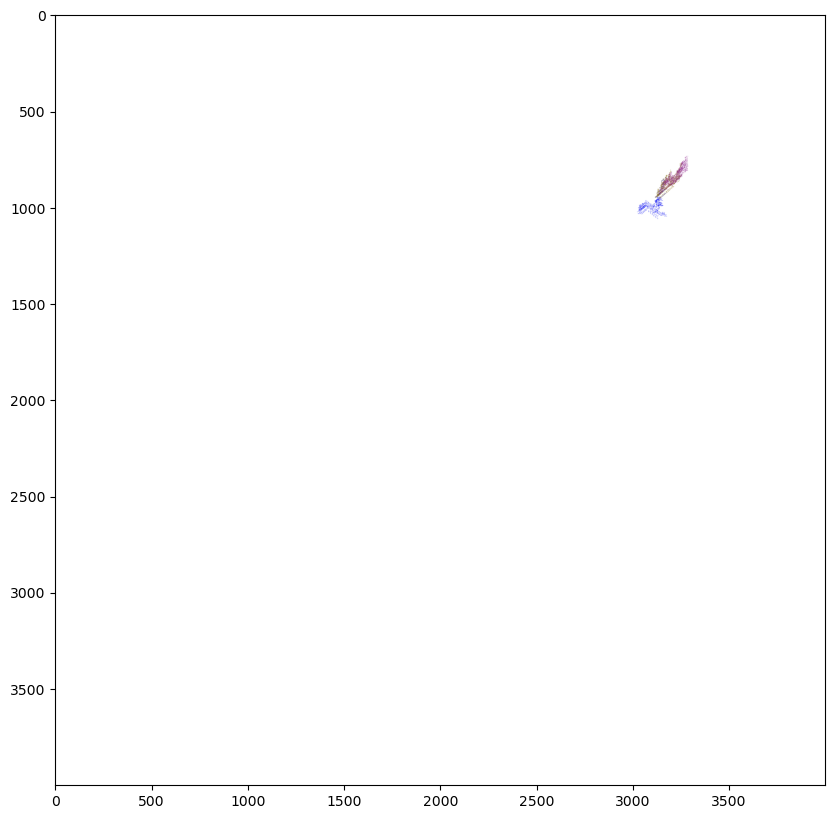

In [4]:
# Extract and plot points from single track, including frame index (HOTA and MOTA version)

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import os
import matplotlib.animation as animation
import pandas as pd
#from PIL import Image
import matplotlib.image
#import trackeval

sequence='07'
series = 'MOT_600K_4S_TR_1_LITE_07_0p3'

#sequence='01'
#series = 'MOT_300K_4S_TR_1_LITE'

calib_file = open('Z:\data_odometry_velodyne\dataset\sequences\\' + sequence + '\calib.txt', 'r')
calib = {}
for line in calib_file:
    key, content = line.strip().split(":")
    values = [float(v) for v in content.strip().split()]
    pose = np.zeros((4, 4))
    pose[0, 0:4] = values[0:4]
    pose[1, 0:4] = values[4:8]
    pose[2, 0:4] = values[8:12]
    pose[3, 3] = 1.0
    calib[key] = pose
calib_file.close()
poses = []
Tr = calib["Tr"]
Tr_inv = np.linalg.inv(Tr)
pose_file = open('Z:\data_odometry_velodyne\dataset\sequences\\' + sequence + '\poses.txt', 'r')
for line in pose_file:
    values = [float(v) for v in line.strip().split()]
    pose = np.zeros((4, 4))
    pose[0, 0:4] = values[0:4]
    pose[1, 0:4] = values[4:8]
    pose[2, 0:4] = values[8:12]
    pose[3, 3] = 1.0
    poses.append(np.matmul(Tr_inv, np.matmul(pose, Tr)))
pose_file.close()

#trax_fn='Z:/PHD/pcseg/results/'+series+'_TRACKING.csv'
#series = 'MOT_300K_4S_TR_1_LITE_06_0p3'
csv_path = 'Z:/PHD/pcseg/results/lrg/'+series
track_fn = 'Z:/PHD/pcseg/results/'+series+'_SEGSHOTA_NC_F.csv'
alldata = pd.read_csv(track_fn,header=None).to_numpy()

print(alldata.shape)
N=alldata.shape[0]
unique_nc=np.unique(alldata[:,0:3], axis=0)
NT=unique_nc.shape[0]
print(N,NT)

scale = 16 #4
imgsz=4000

rot1=45
rot2=45
rot3=0
r = R.from_euler('zyx', [rot1, rot2, rot3], degrees=True)


fig2,ax2 = plt.subplots(figsize=(10, 10))
for w in range(973,974):#NT):
    rr=unique_nc[w,0]
    gg=unique_nc[w,1]
    bb=unique_nc[w,2]
    index_seg=-1
    for i in range(N):
        if rr==alldata[i,0] and gg==alldata[i,1] and bb==alldata[i,2]: 
            index_seg=i
            break
    print(w,index_seg)
    rgbn=[alldata[index_seg,0],alldata[index_seg,1],alldata[index_seg,2]]
    #print(rgbn)

    indl_seg=[]
    for i in range(N):
        if alldata[i,0:3].tolist()==rgbn:
            indl_seg.append(i)

    #print(indl_seg)
    N_f=len(indl_seg)
    print(N_f)
    
    rgb=np.full((imgsz,imgsz,3),255,dtype=np.uint8)

    for i in range(N_f):
        if (i%3)==0:
            #print('Track Frame index',i)
            F=int(alldata[indl_seg[i],3])
            #print('Global Frame index',F)
            csv_fn=csv_path+'/M_'+str(F)+'.csv'
    
            R_world_local = poses[F][:3, :3]
            t_world_local = poses[F][:3, 3]
            R_local_world = np.linalg.inv(R_world_local)
    
            rgbs=[alldata[indl_seg[i],11],alldata[indl_seg[i],12],alldata[indl_seg[i],13]]
    
            pts=[]
            cloud = pd.read_csv(csv_fn,header=None).to_numpy()
            N_p=cloud.shape[0]
            for k in range(N_p):
                rr=cloud[k,3]
                gg=cloud[k,4]
                bb=cloud[k,5]
                if rr==rgbs[0] and gg==rgbs[1] and bb==rgbs[2]:
                    pts.append([cloud[k,0],cloud[k,1],cloud[k,2]])
            N_c=len(pts)
            print(N_c)
    
            for k in range(N_c):
            
                xyz_w=np.asarray([pts[k][0],pts[k][1],pts[k][2]])
                xyz_l=xyz_w #- t_world_local
                #xyz_l=xyz_l.dot(R_local_world.T) 
        
                vr=r.apply([xyz_l[0],xyz_l[1],xyz_l[2]])
                x=int(vr[0]*scale)+int(imgsz/2)
                y=int(vr[1]*scale)+int(imgsz/2)
                if (x>=1) and (x<imgsz-1) and (y>=1) and (y<imgsz-1):
                    rr=255-rgbs[0]
                    gg=255-rgbs[1]
                    bb=255-rgbs[2]
                    rgb[x,y,0]=rr
                    rgb[x,y,1]=gg
                    rgb[x,y,2]=bb
                    rgb[x+1,y,0]=rr
                    rgb[x+1,y,1]=gg
                    rgb[x+1,y,2]=bb
                    rgb[x-1,y,0]=rr
                    rgb[x-1,y,1]=gg
                    rgb[x-1,y,2]=bb
                    rgb[x,y+1,0]=rr
                    rgb[x,y+1,1]=gg
                    rgb[x,y+1,2]=bb
                    rgb[x,y-1,0]=rr
                    rgb[x,y-1,1]=gg
                    rgb[x,y-1,2]=bb
                
                

    im = ax2.imshow(rgb)
    if N_f>1:
        #plt.savefig('Z:/PHD/pcseg/results/'+sequence+'/'+series+'_'+str(int(w))+'_'+str(int(index_seg))+'_TRK_CLOUD_v2.png')
        matplotlib.image.imsave('Z:/PHD/pcseg/results/'+sequence+'/'+series+'_'+str(int(w))+'_'+str(int(index_seg))+'_TRK_CLOUD_V3.png', rgb)


In [ ]:
# Plot global segmentation results

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import os
import matplotlib.animation as animation
import pandas as pd
#from PIL import Image
import matplotlib.image
#import trackeval

sequence='06'
series = 'MOT_300K_4S_TR_1_LITE_06_0p3'

#sequence='01'
#series = 'MOT_300K_4S_TR_1_LITE'

calib_file = open('Z:\data_odometry_velodyne\dataset\sequences\\' + sequence + '\calib.txt', 'r')
calib = {}
for line in calib_file:
    key, content = line.strip().split(":")
    values = [float(v) for v in content.strip().split()]
    pose = np.zeros((4, 4))
    pose[0, 0:4] = values[0:4]
    pose[1, 0:4] = values[4:8]
    pose[2, 0:4] = values[8:12]
    pose[3, 3] = 1.0
    calib[key] = pose
calib_file.close()
poses = []
Tr = calib["Tr"]
Tr_inv = np.linalg.inv(Tr)
pose_file = open('Z:\data_odometry_velodyne\dataset\sequences\\' + sequence + '\poses.txt', 'r')
for line in pose_file:
    values = [float(v) for v in line.strip().split()]
    pose = np.zeros((4, 4))
    pose[0, 0:4] = values[0:4]
    pose[1, 0:4] = values[4:8]
    pose[2, 0:4] = values[8:12]
    pose[3, 3] = 1.0
    poses.append(np.matmul(Tr_inv, np.matmul(pose, Tr)))
pose_file.close()

csv_path = 'Z:/PHD/pcseg/results/lrg/'+series
csv_names = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(csv_path)) for f in fn]
csv_names.sort()

N_f = len(csv_names)
print(N_f)

scale = 3
imgsz=1000

rgb=np.zeros((imgsz,imgsz,3),dtype=np.uint8)

rot1=45
rot2=45
rot3=0
r = R.from_euler('zyx', [rot1, rot2, rot3], degrees=True)

fig2,ax2 = plt.subplots(figsize=(10, 10))

for w in range(N_f):
    csv_fn=csv_path+'/M_'+str(w)+'.csv'
    
    R_world_local = poses[F][:3, :3]
    t_world_local = poses[F][:3, 3]
    R_local_world = np.linalg.inv(R_world_local)
    
    cloud = pd.read_csv(csv_fn,header=None).to_numpy()
    N_p=cloud.shape[0]
    print(w)
    
    
    for k in range(N_p):
        xyz_w=np.asarray([cloud[k,0],cloud[k,1],cloud[k,2]])
        xyz_l=xyz_w #- t_world_local
        #xyz_l=xyz_l.dot(R_local_world.T) 
        
        vr=r.apply([xyz_l[0],xyz_l[1],xyz_l[2]])
        x=int(vr[0]*scale)+int(imgsz/2)
        y=int(vr[1]*scale)+int(imgsz/2)
        if (x>=1) and (x<imgsz-1) and (y>=1) and (y<imgsz-1):
            rr=int(cloud[k,3])
            gg=int(cloud[k,4])
            bb=int(cloud[k,5])
            rgb[x,y,0]=rr
            rgb[x,y,1]=gg
            rgb[x,y,2]=bb
                
            """
            rgb[x+1,y,0]=rr
            rgb[x+1,y,1]=gg
            rgb[x+1,y,2]=bb
            rgb[x-1,y,0]=rr
            rgb[x-1,y,1]=gg
            rgb[x-1,y,2]=bb
            rgb[x,y+1,0]=rr
            rgb[x,y+1,1]=gg
            rgb[x,y+1,2]=bb
            rgb[x,y-1,0]=rr
            rgb[x,y-1,1]=gg
            rgb[x,y-1,2]=bb
            """ 

im = ax2.imshow(rgb)
    

In [ ]:
# Plot global KITTI point clouds

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import os
import matplotlib.animation as animation
import pandas as pd
#from PIL import Image
import matplotlib.image
#import trackeval

sequence='06'


calib_file = open('Z:\data_odometry_velodyne\dataset\sequences\\' + sequence + '\calib.txt', 'r')
calib = {}
for line in calib_file:
    key, content = line.strip().split(":")
    values = [float(v) for v in content.strip().split()]
    pose = np.zeros((4, 4))
    pose[0, 0:4] = values[0:4]
    pose[1, 0:4] = values[4:8]
    pose[2, 0:4] = values[8:12]
    pose[3, 3] = 1.0
    calib[key] = pose
calib_file.close()
poses = []
Tr = calib["Tr"]
Tr_inv = np.linalg.inv(Tr)
pose_file = open('Z:\data_odometry_velodyne\dataset\sequences\\' + sequence + '\poses.txt', 'r')
for line in pose_file:
    values = [float(v) for v in line.strip().split()]
    pose = np.zeros((4, 4))
    pose[0, 0:4] = values[0:4]
    pose[1, 0:4] = values[4:8]
    pose[2, 0:4] = values[8:12]
    pose[3, 3] = 1.0
    poses.append(np.matmul(Tr_inv, np.matmul(pose, Tr)))
pose_file.close()

scan_paths = 'Z:\data_odometry_velodyne\dataset\sequences\\' + sequence + '\\velodyne'
scan_names = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(scan_paths)) for f in fn]
# scan_names=os.listdir(scan_paths)
scan_names.sort()
print('Scans: ',len(scan_names))

N_f = len(scan_names)

scale = 2
imgsz=2000

rgb=np.zeros((imgsz,imgsz,3),dtype=np.uint8)

rot1=45
rot2=45
rot3=0
r = R.from_euler('zyx', [rot1, rot2, rot3], degrees=True)

fig2,ax2 = plt.subplots(figsize=(10, 10))

colors=np.random.randint(0,255,(N_f,3))

for w in range(0,N_f,20):
    velo_fn=scan_paths+'\\'+str(w).zfill(6)+'.bin'
    
    scan = np.fromfile(velo_fn, dtype=np.float32)
    scan = scan.reshape((-1, 4))
    
    # get XYZ in world coordinate frame
    xyz_local = scan[:, 0:3]
    
    R_world_local = poses[w][:3, :3]
    t_world_local = poses[w][:3, 3]
    R_local_world = np.linalg.inv(R_world_local)
    
    N_p=xyz_local.shape[0]
    print(w,N_p)
    
    
    for k in range(N_p):
        xyz_l=np.asarray([xyz_local[k,0],xyz_local[k,1],xyz_local[k,2]])
        
        xyz_l=xyz_l.dot(R_world_local.T)
        xyz_w=xyz_l + t_world_local
        
        vr=r.apply([xyz_w[0],xyz_w[1],xyz_w[2]])
        x=int(vr[0]*scale)+int(imgsz/2)
        y=int(vr[1]*scale)+int(imgsz/2)
        if (x>=1) and (x<imgsz-1) and (y>=1) and (y<imgsz-1):
            rgb[x,y,0]=colors[w,0]
            rgb[x,y,1]=colors[w,1]
            rgb[x,y,2]=colors[w,2]
                
            

im = ax2.imshow(rgb)

